In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

# Домашняя работа 
### Урок 1. Основы обучения нейронных сетей

### Loading dataset

In [15]:
# Lodaing dataset
from sklearn import datasets
X = datasets.load_iris().data
y = datasets.load_iris().target
print(f'Iris data shape: {X.shape}. Iris target shape: {y.shape}.')

# Normalization 
X = Normalizer().fit_transform(X)

# Target binarization
y = np.eye(np.max(y)+1)[y]

# Splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 10)
print('',f'X_train shape: {X_train.shape}.',
            f'X_test shape: {X_test.shape}.',
            f'y_train shape: {y_train.shape}.',
            f'X_train shape: {y_test.shape}.',sep='\n')

Iris data shape: (150, 4). Iris target shape: (150,).

X_train shape: (100, 4).
X_test shape: (50, 4).
y_train shape: (100, 3).
X_train shape: (50, 3).


### Initial functions for NN building (partualy copied from lesson notebook)

In [16]:
# Sigmoid functions

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [17]:
# random weights generator

def generate_weights(neurons, random_s = 1):
    np.random.seed(random_s)
    neurons = list(neurons)
    weights = []
    weights.append(np.random.uniform(-1, 1, size=(4, neurons[0])))
    for i in range (1,len(neurons)):
        weights.append(np.random.uniform(-1, 1, size=(neurons[i-1], neurons[i])))
    weights.append(np.random.uniform(-1, 1, size=(neurons[-1], 3)))
    return weights

In [18]:
# feel forward

def feed_forward(data, weights):
    layers = []
    layers.append(data)
    for i in weights:
        layers.append(sigmoid(np.dot(layers[-1], i)))
    return layers

In [19]:
# evaluate error-accuracy

def evaluate_error( weights , train = True):
    if train:
        evaluate_  = feed_forward(X_train, weights)[-1]
        return (1 - np.mean(np.abs(y_train - evaluate_ ))) * 100
    else:
        evaluate_  = feed_forward(X_test, weights)[-1]
        return (1 - np.mean(np.abs(y_test - evaluate_ ))) * 100


In [20]:
# back propogation 

def back_propogation(epoch, weights, L_rate = 0.1, acc = False ):
    acc_train, acc_test = [], []
    for _ in range(epoch):
        layers = feed_forward(X_train, weights)
        
        layer_error = y_train - layers[-1]

        for s in range (len(layers)-2,-1,-1):

            layer_delta = layer_error * sigmoid_deriv(layers[s+1])
            layer_error = layer_delta.dot(weights[s].T)
            weights[s] += layers[s].T.dot(layer_delta) * L_rate
        


        if acc:
            acc_train.append(evaluate_error( weights , train = True))
            acc_test.append(evaluate_error(weights, train = False))


    return [acc_train, acc_test] if acc else weights


In [21]:
# simply learning and plotting train test

def neural_network_graph(structure, epoch, L_rate = 0.1):
    weights = generate_weights(structure)
    acc_train, acc_test = back_propogation(epoch, weights, L_rate, acc = True)
    
    plt.plot(acc_train,c='blue',label='Train')
    plt.plot(acc_test,c='red',label = 'Test')
    plt.xlabel('Learning epoch')
    plt.ylabel('Accuracy')
    plt.title(f"Acc_train: {np.round(acc_train[-1],4)} %,  Acc_test: {np.round(acc_test[-1],4)}%")
    plt.legend()
    plt.show()

### 1-layer NN

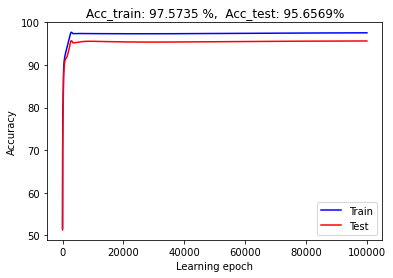

In [22]:
neural_network_graph([5], 100_000, 0.1)

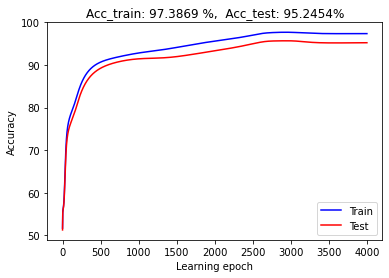

In [23]:
neural_network_graph([5], 4000, 0.1)

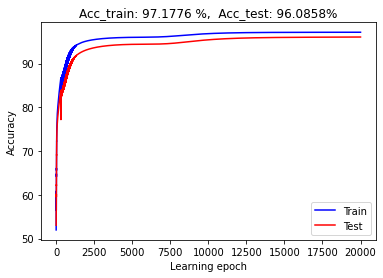

In [24]:
neural_network_graph([25], 20_000, 0.1)

In [25]:
def layer1_nn_comparison (max_neurons, epoch = 10_000, L_rate = 0.1):
    acc_train, acc_test = [],[]
    for i in tqdm(range(max_neurons +1)):
        weights = generate_weights([i])
        acc_tr, acc_te = back_propogation(epoch, weights, L_rate, acc = True)
        acc_train.append(acc_tr[-1])
        acc_test.append(acc_te[-1])
    display(f'Best train: {max(acc_train)}, with {np.argmax(acc_train)} neurons.')
    display(f'Best test: {max(acc_test)}, with {np.argmax(acc_test)} neurons.')
        
    plt.figure(figsize=(20,5))    
    plt.plot(acc_train,c='blue',label='Train',marker = 'o')
    plt.plot(acc_test,c='red',label = 'Test',marker = 'o')
    plt.xticks(np.arange(0, max_neurons +1, 1.0))
    plt.grid()
    plt.ylim(90,100)
    plt.xlim(2,max_neurons+1)

    plt.xlabel('Neurons number')
    plt.ylabel('Accuracy')

    plt.title(f"best_train: {np.round( max(acc_train),4)} %,  best_test: {np.round(max(acc_test),4)}%")
    plt.legend()
    plt.show()

100%|██████████| 51/51 [01:54<00:00,  2.24s/it]


'Best train: 97.84187265118727, with 3 neurons.'

'Best test: 96.48349848037783, with 18 neurons.'

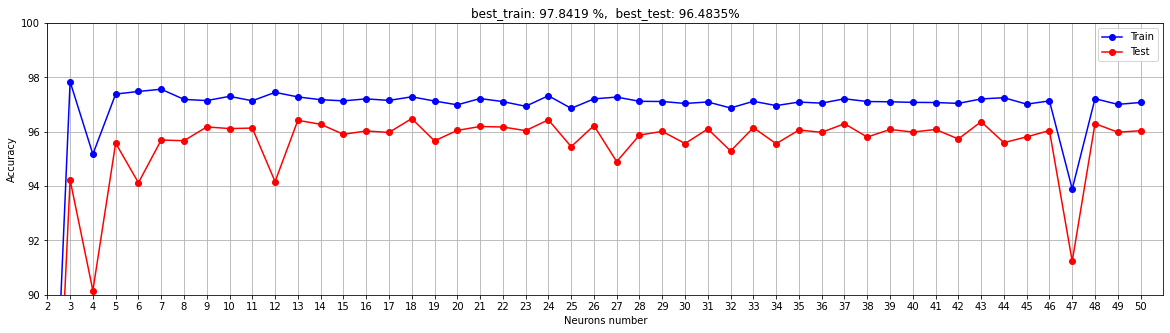

In [26]:
layer1_nn_comparison (50, epoch = 10_000, L_rate = 0.1)

In [27]:
def layer1_nn_hypertuning(neurons=15, steps = 10 , maxL=0.1, minL=0.01, minE=10000, maxE=100000):
    xacc_train, xacc_test = [], []
    l_rate_range = np.linspace(maxL,minL,steps).round(4)
    epoch_range = np.linspace(minE,maxE,steps).astype(int)
    for x in tqdm(l_rate_range):
        acc_train, acc_test = [], []
        for y in epoch_range:
            weights = generate_weights([neurons])
            weights = back_propogation(epoch=y, weights = weights, L_rate=x, acc = False)
            acc_train.append(evaluate_error( weights,train = True))
            acc_test.append(evaluate_error(weights, train = False))
        xacc_train.append(acc_train)
        xacc_test.append(acc_test)
    train_df = pd.DataFrame(np.array(xacc_train), index = l_rate_range,
                     columns = epoch_range )
    test_df = pd.DataFrame(np.array(xacc_test), index = l_rate_range,
                     columns = epoch_range )
    display(f'Max Train:{train_df.max().max()}')
    display(f'Max Test:{test_df.max().max()}')
    return train_df, test_df
    

In [28]:
tr,ts = layer1_nn_hypertuning(neurons=18,steps = 12, maxL=0.1, minL=0.01, minE=5_000, maxE=20_000)

100%|██████████| 12/12 [03:18<00:00, 16.58s/it]


'Max Train:97.48305214643106'

'Max Test:96.653171586548'

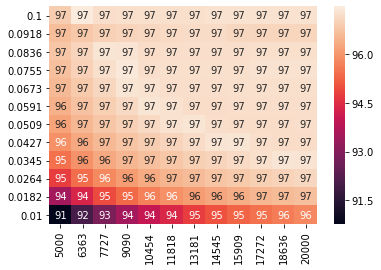

In [29]:
sns.heatmap(tr, annot=True);

In [30]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

In [31]:
pd.DataFrame(tr.idxmax()).merge(pd.DataFrame(tr.max(axis = 0)),
    left_index=True, right_index=True).reset_index().rename(
    columns = {'index':'Epoch','0_x':'L_rate','0_y':'Accuracy'}).style.apply(
    highlight_max, subset = ['Accuracy'])

,Epoch,L_rate,Accuracy
0,5000,0.1,96.9488
1,6363,0.1,97.4831
2,7727,0.0836,97.3585
3,9090,0.0755,97.4398
4,10454,0.0591,97.3525
5,11818,0.0591,97.3173
6,13181,0.0509,97.3732
7,14545,0.0427,97.3459
8,15909,0.0427,97.3628
9,17272,0.1,97.3122


In [32]:
pd.DataFrame(ts.idxmax()).merge(pd.DataFrame(ts.max(axis = 0)),
    left_index=True, right_index=True).reset_index().rename(
    columns = {'index':'Epoch','0_x':'L_rate','0_y':'Accuracy'}).style.apply(
    highlight_max, subset = ['Accuracy'])

,Epoch,L_rate,Accuracy
0,5000,0.1,95.8445
1,6363,0.1,96.6532
2,7727,0.0836,96.4971
3,9090,0.0755,96.5637
4,10454,0.0591,96.4923
5,11818,0.1,96.4937
6,13181,0.1,96.5
7,14545,0.1,96.5057
8,15909,0.1,96.5109
9,17272,0.1,96.5158


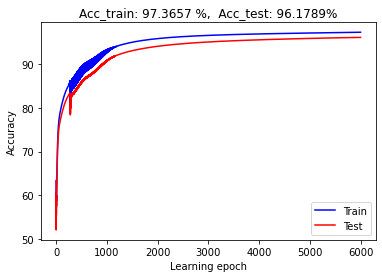

In [34]:
neural_network_graph([16], 6000, 0.1)

## Conclusion 

- увеличение количества нейронов (более 3) не сильно
увеличивает точность на трейне всегда колеблется в пределах 97-98 % 
большое количество епох и малый трэйн_рэйт ведут к переобучению 
- тюнинг гиперпараметров немного улучшил модель 
- опримальное количество нейронов для теста  = 18 (тест = 96.5%)

- нужно попробовать увеличить количество слоев в модели


### 2-layer NN

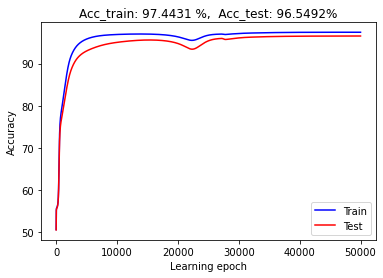

In [35]:
neural_network_graph([10,5], 50_000, 0.01)

In [36]:
def grid_search_2_layers(min_n = 3, max_n = 10, epoch = 10000 , L_rate = 0.1):
    xacc_train, xacc_test = [], []
    for x in tqdm(range(min_n, max_n + 1)):
        acc_train, acc_test = [], []
        for y in range(min_n, max_n + 1):
            weights = generate_weights([x, y])
            weights = back_propogation(epoch, weights, L_rate, acc = False)
            acc_train.append(evaluate_error( weights, train = True))
            acc_test.append(evaluate_error(weights, train = False))
        xacc_train.append(acc_train)
        xacc_test.append(acc_test)
    
    train_df = pd.DataFrame(np.array(xacc_train), index = range(min_n, max_n + 1),
                     columns = range(min_n, max_n + 1) )
    test_df = pd.DataFrame(np.array(xacc_test), index = range(min_n, max_n + 1),
                     columns = range(min_n, max_n + 1) )
    display(f'Max Train:{train_df.max().max()}')
    display(f'Max Test:{test_df.max().max()}')
    return train_df, test_df
            

In [37]:
tr, ts = grid_search_2_layers(min_n = 3, max_n = 15, epoch = 20_000 , L_rate = 0.01)

100%|██████████| 13/13 [07:31<00:00, 34.73s/it]


'Max Train:97.91287582752797'

'Max Test:96.71851131153767'

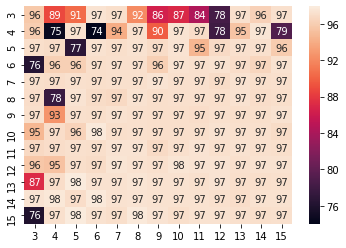

In [38]:
sns.heatmap(tr, annot=True);

In [39]:
pd.DataFrame(tr.idxmax()).merge(pd.DataFrame(tr.max(axis = 0)),
    left_index=True, right_index=True).reset_index().rename(
    columns = {'index':'layer2','0_x':'layer1','0_y':'Accuracy'}).style.apply(
    highlight_max, subset = ['Accuracy'])


,layer2,layer1,Accuracy
0,3,14,97.4052
1,4,14,97.703
2,5,15,97.9129
3,6,14,97.7775
4,7,12,97.4831
5,8,15,97.7427
6,9,15,97.4157
7,10,12,97.5084
8,11,12,97.4403
9,12,13,97.39


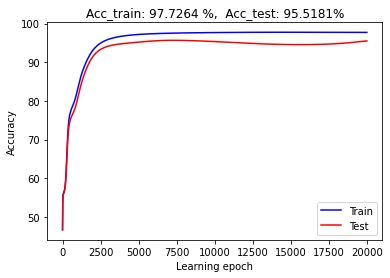

In [41]:
neural_network_graph([10,6], 20_000, 0.01)

In [42]:
pd.DataFrame(ts.idxmax()).merge( pd.DataFrame(ts.max(axis = 0)),
    left_index=True, right_index=True).reset_index().rename(
    columns = {'index':'layer2','0_x':'layer1','0_y':'Accuracy'}).style.apply(
    highlight_max, subset = ['Accuracy'])

,layer2,layer1,Accuracy
0,3,14,96.5335
1,4,13,96.14
2,5,8,96.4532
3,6,14,96.7185
4,7,14,96.5638
5,8,13,96.5852
6,9,7,96.4735
7,10,12,96.6397
8,11,11,96.5979
9,12,13,96.5304


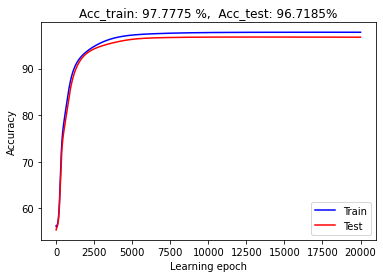

In [44]:
neural_network_graph([14,6], 20_000, 0.01)

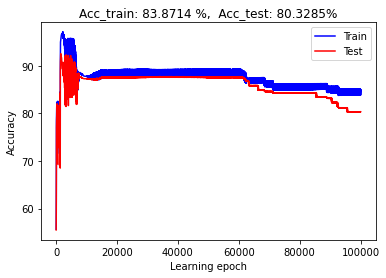

In [45]:
neural_network_graph([5,5], 100_000, 0.1)

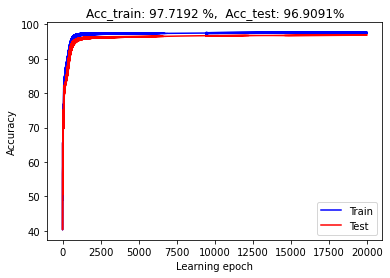

In [47]:
neural_network_graph([20,20], 20_000, 0.1)

## Conclusion 

- видно что сеть стала немного точнее : увеличился результат трейн и тест , уменьшился разрыв между ними.
- при увеличении кол-ва слоев нужно уменьшать трэйн_рэйт иначе появляются сильные колебания в
процессе обучения и качество падает (можно поправить увеличением кол-ва нейронов в обоих слоях ).
-необходимо ограничивать количество эпох обучения (или прерывать обучение) потому, что переобучение.
- опримальное количество нейронов для теста  = [14, 6] 25000 эпох (тест = 97%)
- нужно попробовать увеличить количество слоев в модели.

### Just for lulz

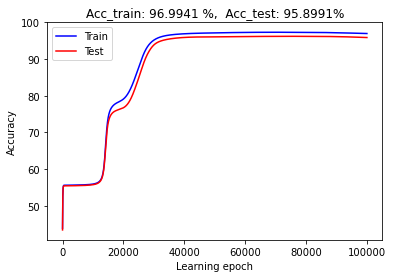

In [48]:
neural_network_graph([10,10,10,10], 100_000, 0.0007)

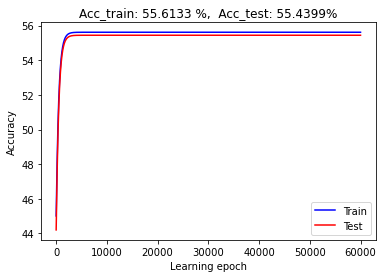

In [49]:
neural_network_graph([10,10,10,10,10,10,10,10,10], 60_000, 0.0001)